In [53]:
## Importing Dependencies
import pandas as pd
import numpy as np
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

import matplotlib.pyplot as plt
import matplotlib.font_manager
import matplotlib as mpl
import seaborn as sns

from glob import glob
from tqdm import tqdm
from scipy import interpolate

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, AveragePooling1D, GlobalAveragePooling1D

In [2]:
w_list = sorted(glob("datasets/water_data/*.csv"))
w_list

['datasets/water_data/data_2012.csv',
 'datasets/water_data/data_2013.csv',
 'datasets/water_data/data_2014.csv',
 'datasets/water_data/data_2015.csv',
 'datasets/water_data/data_2016.csv',
 'datasets/water_data/data_2017.csv',
 'datasets/water_data/data_2018.csv',
 'datasets/water_data/data_2019.csv',
 'datasets/water_data/data_2020.csv',
 'datasets/water_data/data_2021.csv',
 'datasets/water_data/data_2022.csv']

## EDA

### find out outliers and missing values

In [3]:
## matplotlib 한글 깨짐현상 해결
font_list= [f.name for f in matplotlib.font_manager.fontManager.ttflist if 'Nanum' in f.name]
# 유니코드 깨짐현상 해결
mpl.rcParams['axes.unicode_minus'] = False
# 나눔고딕 폰트 적용
plt.rcParams["font.family"] = 'NanumGothic'

In [17]:
data_2012= pd.read_csv(w_list[0])
data_2012

,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630
0,2012-05-01 00:00,24.800,555.0,219.07,24.93,555.0,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18
1,2012-05-01 00:10,24.794,464.6,218.86,25.15,562.9,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18
2,2012-05-01 00:20,24.789,478.1,218.69,25.31,576.4,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18
3,2012-05-01 00:30,24.789,464.8,218.69,25.31,563.1,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17
4,2012-05-01 00:40,24.789,478.1,218.69,25.31,576.4,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26491,2012-10-31 23:10,25.250,270.2,235.01,8.99,270.2,300.0,372.7,1018.67,364.2,0.0,365.0,1395.30,351.3,1837.11
26492,2012-10-31 23:20,25.250,264.1,235.01,8.99,264.1,286.0,365.7,945.75,359.2,0.0,362.0,1154.21,350.3,1814.92
26493,2012-10-31 23:30,25.250,257.9,235.01,8.99,257.9,273.0,362.7,915.35,356.2,0.0,359.0,968.58,349.3,1792.88
26494,2012-10-31 23:40,25.250,264.1,235.01,8.99,264.1,261.0,355.7,846.39,352.2,0.0,356.0,776.99,346.3,1727.56


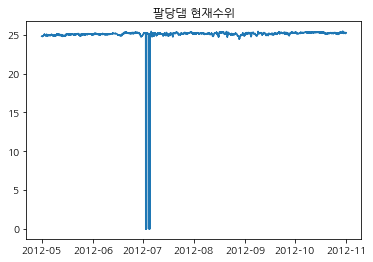

In [19]:
plt.plot(pd.to_datetime(data_2012.ymdhm), data_2012.swl) ## swl = 팔당댐 현재수위
plt.title('팔당댐 현재수위')
plt.show()

In [24]:
## Before jump into detect outliers, interpolate null values.
swl_null_check= data_2012[data_2012.swl.isna()]
print(len(swl_null_check))

## the length of null values of 'swl' and the other values is just 1.
## It is so small that we are able to ignore the value.
data_2012= data_2012[data_2012.swl.notna()].reset_index(drop=True)

## There are some outliers, so it should be removed.
## In order to detect the outliers, use IQR method.
outliers= data_2012[data_2012.swl== 0]
print('the number of outliers is ' + str(len(outliers)))

0
the number of outliers is 68


In [25]:
## IQR method
q1= np.percentile(data_2012.swl, 25)
q3= np.percentile(data_2012.swl, 75)
iqr= q3-q1
data_2012_processed= data_2012[(data_2012.swl > q1-1.5*iqr) & (data_2012.swl < q3+1.5*iqr)].reset_index(drop=True)
data_2012_processed

,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630
0,2012-05-01 00:00,24.800,555.0,219.07,24.93,555.0,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18
1,2012-05-01 00:10,24.794,464.6,218.86,25.15,562.9,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18
2,2012-05-01 00:20,24.789,478.1,218.69,25.31,576.4,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18
3,2012-05-01 00:30,24.789,464.8,218.69,25.31,563.1,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17
4,2012-05-01 00:40,24.789,478.1,218.69,25.31,576.4,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26128,2012-10-31 23:10,25.250,270.2,235.01,8.99,270.2,300.0,372.7,1018.67,364.2,0.0,365.0,1395.30,351.3,1837.11
26129,2012-10-31 23:20,25.250,264.1,235.01,8.99,264.1,286.0,365.7,945.75,359.2,0.0,362.0,1154.21,350.3,1814.92
26130,2012-10-31 23:30,25.250,257.9,235.01,8.99,257.9,273.0,362.7,915.35,356.2,0.0,359.0,968.58,349.3,1792.88
26131,2012-10-31 23:40,25.250,264.1,235.01,8.99,264.1,261.0,355.7,846.39,352.2,0.0,356.0,776.99,346.3,1727.56


In [26]:
data_2012_processed.columns
## 측정변수 x_value
# swl : 팔당댐 현재수위 (단위: El.m)
# inf : 팔당댐 유입량 (단위: m^3/s)
# sfw : 팔당댐 저수량 (단위: 만m^3)
# ecpc : 팔당댐 공용량 (단위: 백만m^3)
# tototf : 총 방류량 (단위: m^3/s)
# tide_level : 강화대교 조위 (단위: cm)
# fw_1018662 : 청담대교 유량 (단위: m^3/s)
# fw_1018680 : 잠수교 유량 (단위: m^3/s)
# fw_1018683 : 한강대교 유량 (단위: m^3/s)
# fw_1019630 : 행주대교 유량 (단위: m^3/s)

## 예측해야 하는 y value는
# 1. "wl_1018662": 청담대교 수위
# 2. "wl_1018680": 잠수교 수위
# 3. "wl_1018683": 한강대교 수위
# 4. "wl_1019630": 행주대교 수위

Index(['ymdhm', 'swl', 'inf', 'sfw', 'ecpc', 'tototf', 'tide_level',
       'wl_1018662', 'fw_1018662', 'wl_1018680', 'fw_1018680', 'wl_1018683',
       'fw_1018683', 'wl_1019630', 'fw_1019630'],
      dtype='object')

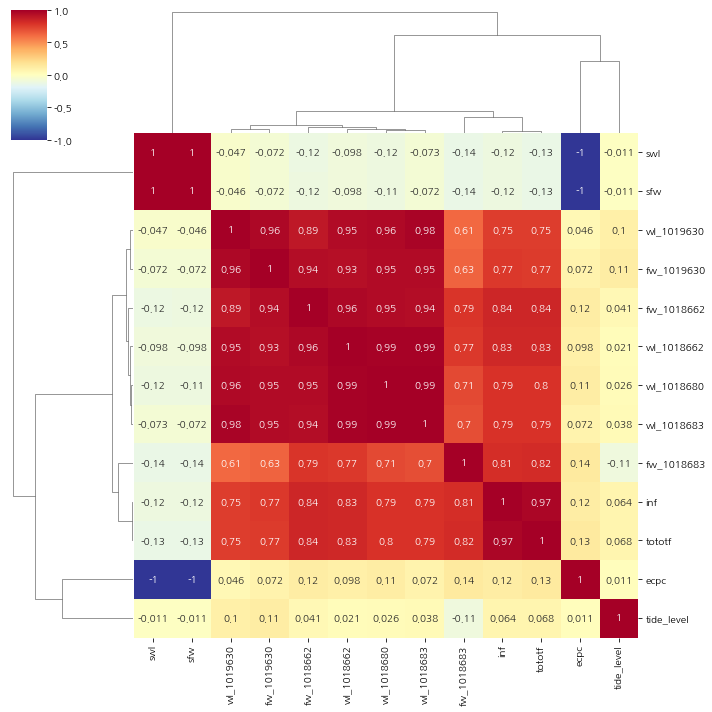

In [28]:
## 잠수교 유량(fw_1018680)데이터는 모두 0이기 때문에, 제거
df= data_2012_processed.loc[:, ['ymdhm', 'swl', 'inf', 'sfw', 'ecpc', 'tototf', 'tide_level',
       'wl_1018662', 'fw_1018662', 'wl_1018680', 'wl_1018683',
       'fw_1018683', 'wl_1019630', 'fw_1019630']].corr()

sns.clustermap(df, 
               annot = True,      # 실제 값 화면에 나타내기
               cmap = 'RdYlBu_r',  # Red, Yellow, Blue 색상으로 표시
               vmin = -1, vmax = 1, #컬러차트 -1 ~ 1 범위로 표시
              )

/tmp/ipykernel_8176/3970485646.py:56: UserWarning: Attempting to set identical bottom == top == 0 results in singular transformations; automatically expanding.
  plt.ylim(0, max(y_value8))


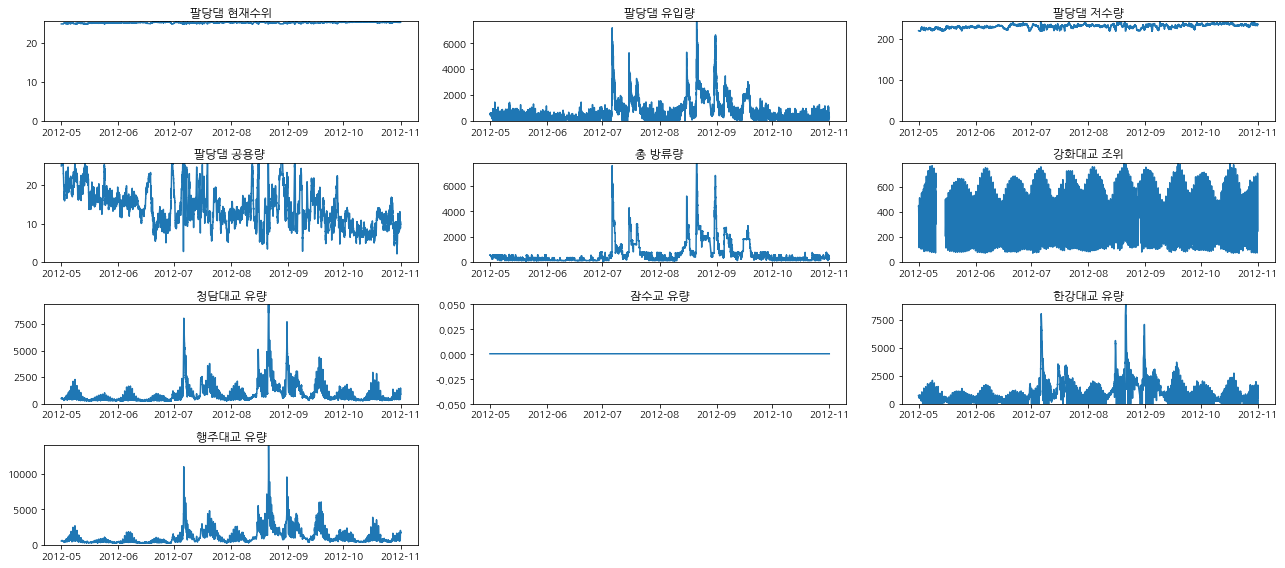

In [44]:
## look out all of values
def visualze_values(data_2012_processed):
    %matplotlib inline
    plt.subplots(figsize=(18,8 ))
    
    x_value= pd.to_datetime(data_2012_processed.ymdhm)
    y_value1= data_2012_processed['swl']
    y_value2= data_2012_processed['inf']
    y_value3= data_2012_processed['sfw']
    y_value4= data_2012_processed['ecpc']
    y_value5= data_2012_processed['tototf']
    y_value6= data_2012_processed['tide_level']
    y_value7= data_2012_processed['fw_1018662']
    y_value8= data_2012_processed['fw_1018680']
    y_value9= data_2012_processed['fw_1018683']
    y_value10= data_2012_processed['fw_1019630']

    plt.subplot(4,3,1)
    plt.plot(x_value, y_value1)
    plt.title('팔당댐 현재수위')
    plt.ylim(0, max(y_value1))

    plt.subplot(4,3,2)
    plt.plot(x_value, y_value2)
    plt.title('팔당댐 유입량')
    plt.ylim(0, max(y_value2))

    plt.subplot(4,3,3)
    plt.plot(x_value, y_value3)
    plt.title('팔당댐 저수량')
    plt.ylim(0, max(y_value3))

    plt.subplot(4,3,4)
    plt.plot(x_value, y_value4)
    plt.title('팔당댐 공용량 ')
    plt.ylim(0, max(y_value4))

    plt.subplot(4,3,5)
    plt.plot(x_value, y_value5)
    plt.title('총 방류량')
    plt.ylim(0, max(y_value5))
    
    plt.subplot(4,3,6)
    plt.plot(x_value, y_value6)
    plt.title('강화대교 조위')
    plt.ylim(0, max(y_value6))
    
    plt.subplot(4,3,7)
    plt.plot(x_value, y_value7)
    plt.title('청담대교 유량')
    plt.ylim(0, max(y_value7))
    
    plt.subplot(4,3,8)
    plt.plot(x_value, y_value8)
    plt.title('잠수교 유량')
    plt.ylim(0, max(y_value8))

    plt.subplot(4,3,9)
    plt.plot(x_value, y_value9)
    plt.title('한강대교 유량')
    plt.ylim(0, max(y_value9))

    plt.subplot(4,3,10)
    plt.plot(x_value, y_value10)
    plt.title('행주대교 유량')
    plt.ylim(0, max(y_value10))
    plt.tight_layout()
    plt.show()

visualze_values(data_2012_processed)

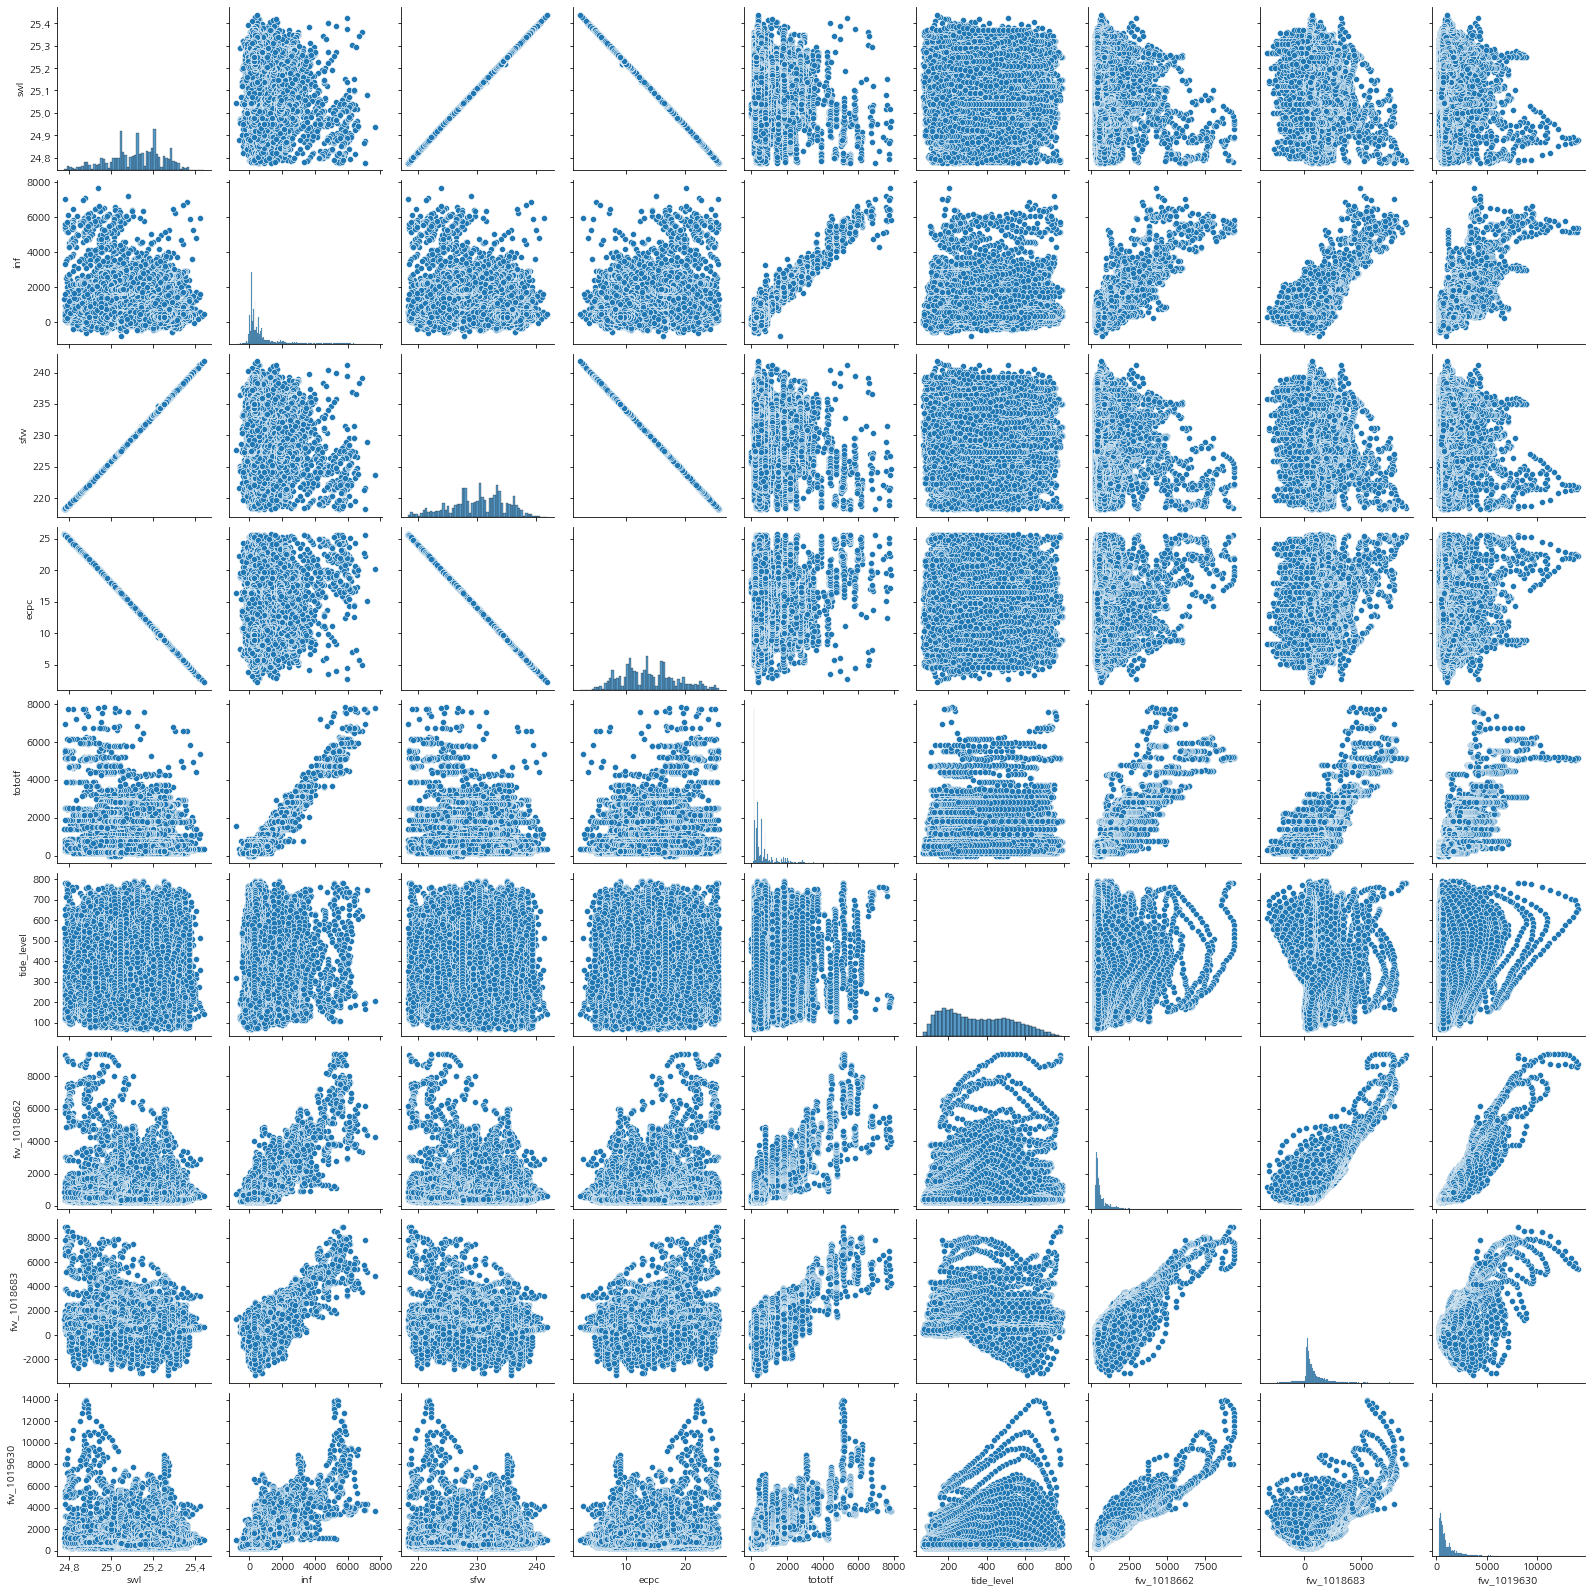

In [77]:
## for checking out multicolinearity, plot independent variables with seaborn packages.
sns.pairplot(data_2012_processed[['swl', 'inf', 'sfw', 'ecpc', 'tototf', 'tide_level',
       'fw_1018662', 'fw_1018683', 'fw_1019630']])
plt.show()

## 다중공선성 및 유의미한 변수 추출

In [72]:
#### OLS 및 다중공선성 확인

In [79]:
import statsmodels.api as sm;
data_2012_processed['intercept']= 1
model= sm.OLS(data_2012_processed['wl_1018662'], data_2012_processed[['swl', 'inf', 'sfw', 'ecpc', 'tototf', 
       'fw_1018662', 'fw_1018683', 'fw_1019630']])
results= model.fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:             wl_1018662   R-squared (uncentered):                   0.998
Model:                            OLS   Adj. R-squared (uncentered):              0.998
Method:                 Least Squares   F-statistic:                          1.475e+06
Date:                Fri, 05 Aug 2022   Prob (F-statistic):                        0.00
Time:                        12:01:46   Log-Likelihood:                     -1.0988e+05
No. Observations:               26133   AIC:                                  2.198e+05
Df Residuals:                   26125   BIC:                                  2.198e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [84]:
dfx= data_2012_processed.loc[:, ['swl', 'inf', 'sfw', 'ecpc', 'tototf', 
       'fw_1018662', 'fw_1018683', 'fw_1019630']]

In [85]:
## 예측하고자 하는 y변수는 총 4개이다(각 대교별 수위)
## 각 대교별로 유의미한 x변수를 추출해야 한다.
## 다중공선성 추출 결과, 모든 독립변수(x_value)의 다중공선성이 5 이상이다. 이를  해결하기 위해 정규화 모델링을 하도록 한다.
vif= pd.DataFrame()
vif["VIF Factor"]= [variance_inflation_factor(dfx.values, i) for i in range(dfx.shape[1])]
vif["features"]= dfx.columns
vif= vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,6.943616e+00,fw_1018683
1,2.553348e+01,fw_1019630
2,3.024610e+01,inf
3,3.168952e+01,tototf
4,3.725963e+01,fw_1018662
5,8.171033e+05,ecpc
6,3.726981e+08,sfw
7,4.063941e+08,swl


In [86]:
## Ridge Regression
from sklearn.linear_model import Ridge

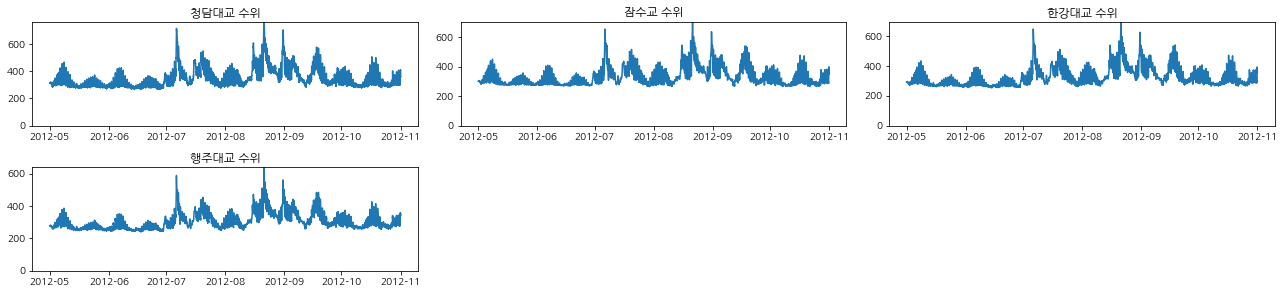

In [87]:
## look out all of y values
## They look after each other, but there are somewhat differences among the data.
def visualze_values(data_2012_processed):
    %matplotlib inline
    plt.subplots(figsize=(18,8 ))
    
    x_value= pd.to_datetime(data_2012_processed.ymdhm)
    y_value1= data_2012_processed['wl_1018662']
    y_value2= data_2012_processed['wl_1018680']
    y_value3= data_2012_processed['wl_1018683']
    y_value4= data_2012_processed['wl_1019630']

    plt.subplot(4,3,1)
    plt.plot(x_value, y_value1)
    plt.title('청담대교 수위')
    plt.ylim(0, max(y_value1))

    plt.subplot(4,3,2)
    plt.plot(x_value, y_value2)
    plt.title('잠수교 수위')
    plt.ylim(0, max(y_value2))

    plt.subplot(4,3,3)
    plt.plot(x_value, y_value3)
    plt.title('한강대교 수위')
    plt.ylim(0, max(y_value3))

    plt.subplot(4,3,4)
    plt.plot(x_value, y_value4)
    plt.title('행주대교 수위')
    plt.ylim(0, max(y_value4))

    plt.tight_layout()
    plt.show()

visualze_values(data_2012_processed)

In [139]:
## For setting Ridge regression model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [138]:
## object for Ridge regression
rdg= Ridge(alpha=0.01)
rdg.fit(X_train, y_train)
rdg_pred= rdg.predict(X_test)
## check out performance index
print("Ridge 훈련 세트 점수 : {:.3f}".format(rdg.score(X_train, y_train)))
print("Ridge 테스트 세트 점수 : {:.3f}".format(rdg.score(X_test, y_test)))
rdg_pred

Ridge 훈련 세트 점수 : 0.938
Ridge 테스트 세트 점수 : 0.941


array([520.81881246, 315.8459453 , 335.53792005, ..., 301.22121641,
       356.01088558, 301.83837641])

In [110]:
## object for Lasso regression
lasso= Lasso()
lasso.fit(X_train, y_train)
lasso_pred= lasso.predict(X_test)
## check out performance index
print("Lasso 훈련 세트 점수 : {:.3f}".format(lasso.score(X_train, y_train)))
print("Lasso 테스트 세트 점수 : {:.3f}".format(lasso.score(X_test, y_test)))
lasso_pred

Lasso 훈련 세트 점수 : 0.938
Lasso 테스트 세트 점수 : 0.941


array([520.54384946, 316.00506755, 334.98023354, ..., 300.65919002,
       355.6950509 , 301.98019329])

In [102]:
## object for ElasticNet regression
elastic= ElasticNet()
elastic.fit(X_train, y_train)
## check out performance index
print("Lasso 훈련 세트 점수 : {:.3f}".format(elastic.score(X_train, y_train)))
print("Lasso 테스트 세트 점수 : {:.3f}".format(elastic.score(X_test, y_test)))

Lasso 훈련 세트 점수 : 0.938
Lasso 테스트 세트 점수 : 0.941


In [ ]:
## ridge, lasso, elasticnet 모두 성능은 비슷한 것으로 판단됨

## Inference

In [177]:
## 전체 데이터 병합하기
w_list = sorted(glob("datasets/water_data/*.csv"))

dataset_flood= pd.DataFrame()
for i in range(len(w_list)):
    dataset_flood= pd.concat([dataset_flood, pd.read_csv(w_list[i])], axis=0)
dataset_flood.reset_index(drop=True)

,ymdhm,swl,inf,sfw,ecpc,tototf,tide_level,wl_1018662,fw_1018662,wl_1018680,fw_1018680,wl_1018683,fw_1018683,wl_1019630,fw_1019630
0,2012-05-01 00:00,24.800,555.00,219.07,24.93,555.00,445.0,310.7,469.05,300.2,0.0,290.0,729.80,275.3,540.18
1,2012-05-01 00:10,24.794,464.60,218.86,25.15,562.90,449.0,314.7,498.00,300.2,0.0,290.0,731.48,275.3,540.18
2,2012-05-01 00:20,24.789,478.10,218.69,25.31,576.40,451.0,313.7,490.68,301.2,0.0,290.0,726.42,275.3,540.18
3,2012-05-01 00:30,24.789,464.80,218.69,25.31,563.10,452.0,311.7,476.21,301.2,0.0,290.0,726.42,276.3,552.17
4,2012-05-01 00:40,24.789,478.10,218.69,25.31,576.40,450.0,311.7,476.21,301.2,0.0,291.0,707.17,277.3,564.29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276331,2022-07-18 23:10,25.040,259.23,212.86,31.14,259.23,510.0,0.0,319.84,0.0,NaN,0.0,-456.41,0.0,974.40
276332,2022-07-18 23:20,25.040,260.46,212.86,31.14,260.46,492.0,0.0,314.01,0.0,NaN,0.0,-717.30,0.0,1006.88
276333,2022-07-18 23:30,25.040,259.37,212.86,31.14,259.37,475.0,0.0,387.55,0.0,NaN,0.0,-843.37,0.0,1039.90
276334,2022-07-18 23:40,25.040,259.13,212.86,31.14,259.13,458.0,0.0,454.91,0.0,NaN,0.0,-1023.37,0.0,1073.46


In [ ]:
plt.plot(dataset_flood.ymdhm, dataset_flood.swl)
plt.show()

In [178]:
dataset_flood.columns

Index(['ymdhm', 'swl', 'inf', 'sfw', 'ecpc', 'tototf', 'tide_level',
       'wl_1018662', 'fw_1018662', 'wl_1018680', 'fw_1018680', 'wl_1018683',
       'fw_1018683', 'wl_1019630', 'fw_1019630'],
      dtype='object')

In [173]:
## 청담대교 수위 예측
dataset_flood
real_check= real[real.index >= ]
X= data_2012_processed.loc[:, ['swl', 'inf', 'sfw', 'ecpc', 'tototf', 
       'fw_1018662', 'fw_1018683', 'fw_1019630']]
y= data_2012_processed['wl_1018662'] # 청담대교 수위

start= baseline.ymdhm[0]

X_test= real_check[['swl', 'inf', 'sfw', 'ecpc', 'tototf', 
       'fw_1018662', 'fw_1018683', 'fw_1019630']]
X_test= X_test.interpolate()
X_test

rdg= Ridge(alpha=0.01)
rdg.fit(X, y)
rdg_pred= rdg.predict(X_test)
rdg_pred

array([521.84510268, 315.62985346, 335.50309525, ..., 301.09301951,
       356.26136393, 301.56042448])

In [ ]:
# 2. "wl_1018680": 잠수교 수위
# 3. "wl_1018683": 한강대교 수위
# 4. "wl_1019630": 행주대교 수위